In [8]:
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer
import base64
from io import BytesIO

In [9]:
class ImageCaptioner:
    def __init__(self, model_path='LiAutoAD/Ristretto-3B',system_prompt="please describe the image."):
        self.IMAGENET_MEAN = (0.5, 0.5, 0.5)
        self.IMAGENET_STD = (0.5, 0.5, 0.5)
        print(f'Loading model from {model_path}...')

        self.model = AutoModel.from_pretrained(
            model_path,
            torch_dtype=torch.bfloat16,
            trust_remote_code=True).eval().cuda()
        
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_path, 
            trust_remote_code=True, 
            use_fast=False)
        
        self.system_history = None
        if system_prompt:
            self._initialize_system_prompt(system_prompt)
        
        
        print('Model loaded successfully.')

    def _initialize_system_prompt(self, system_prompt):
        """Initialize the system prompt and create reusable history."""
        generation_config = dict(max_new_tokens=10, do_sample=False)  # Minimal response
        
        # Create initial conversation with system prompt
        _, self.system_history = self.model.chat(
            self.tokenizer, 
            None, 
            system_prompt, 
            generation_config, 
            history=None, 
            return_history=True
        )
        print(f"System prompt initialized: '{system_prompt[:50]}...'")
    
    def set_system_prompt(self, system_prompt):
        """Set or update the system prompt."""
        self._initialize_system_prompt(system_prompt)

    def build_transform(self, input_size):
        MEAN, STD = self.IMAGENET_MEAN, self.IMAGENET_STD
        transform = T.Compose([
            T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
            T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
            T.ToTensor(),
            T.Normalize(mean=MEAN, std=STD)
        ])
        return transform
    
    def find_closest_aspect_ratio(self, aspect_ratio, target_ratios, width, height, image_size):
        best_ratio_diff = float('inf')
        best_ratio = (1, 1)
        area = width * height
        for ratio in target_ratios:
            target_aspect_ratio = ratio[0] / ratio[1]
            ratio_diff = abs(aspect_ratio - target_aspect_ratio)
            if ratio_diff < best_ratio_diff:
                best_ratio_diff = ratio_diff
                best_ratio = ratio
            elif ratio_diff == best_ratio_diff:
                if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                    best_ratio = ratio
        return best_ratio
    
    def dynamic_preprocess(self, image, min_num=1, max_num=10, image_size=448, use_thumbnail=False):
        orig_width, orig_height = image.size
        aspect_ratio = orig_width / orig_height

        # calculate the existing image aspect ratio
        target_ratios = set(
            (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
            i * j <= max_num and i * j >= min_num)
        target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

        # find the closest aspect ratio to the target
        target_aspect_ratio = self.find_closest_aspect_ratio(
            aspect_ratio, target_ratios, orig_width, orig_height, image_size)

        # calculate the target width and height
        target_width = image_size * target_aspect_ratio[0]
        target_height = image_size * target_aspect_ratio[1]
        blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

        # resize the image
        resized_img = image.resize((target_width, target_height))
        processed_images = []
        for i in range(blocks):
            box = (
                (i % (target_width // image_size)) * image_size,
                (i // (target_width // image_size)) * image_size,
                ((i % (target_width // image_size)) + 1) * image_size,
                ((i // (target_width // image_size)) + 1) * image_size
            )
            # split the image
            split_img = resized_img.crop(box)
            processed_images.append(split_img)
        assert len(processed_images) == blocks
        if use_thumbnail and len(processed_images) != 1:
            thumbnail_img = image.resize((image_size, image_size))
            processed_images.append(thumbnail_img)
        return processed_images
    

    def load_image(self, base64_string, input_size=384, max_num=10):
        # Remove data URL prefix if present
        if ',' in base64_string:
            base64_string = base64_string.split(',')[1]
        
        # Decode base64
        image_data = base64.b64decode(base64_string)
        image_bytes = BytesIO(image_data)
        
        image = Image.open(image_bytes).convert('RGB')
        transform = self.build_transform(input_size=input_size)
        images = self.dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
        pixel_values = [transform(image) for image in images]
        pixel_values = torch.stack(pixel_values)
        return pixel_values
    
    def make_Pil_image(self,image_b64):
        from PIL import Image
        from io import BytesIO
        decoded_image = base64.b64decode(image_b64)
        image = Image.open(BytesIO(decoded_image))
        return image
    def show_image(self,image_b64):
        from IPython.display import display, Image
        display(self.make_Pil_image(image_b64))
        
    def generate_caption(self, base64_string, question='Please describe the image.'):
        """Generate caption for base64 encoded image."""
        self.show_image(base64_string)  # Display the image in the notebook
        pixel_values = self.load_image(base64_string, max_num=10).to(torch.bfloat16).cuda()
        generation_config = dict(max_new_tokens=1024, do_sample=True)
        
        system_prompt = self.system_history if self.system_history else None

        formatted_question = f'<image> {question}'
        response, _ = self.model.chat(
            self.tokenizer, 
            pixel_values, 
            formatted_question, 
            generation_config, 
            history=system_prompt, 
            return_history=True
        )
        return response
    

    




In [ ]:
import json
json_path = "Output/O-RAN.WG3.TS.E2AP-R004-v07.00/O-RAN.WG3.TS.E2AP-R004-v07.00.json"
base64_string = ""
with open(json_path, 'r') as file:
    data = json.load(file)
blocktypes = ["Figure", "FigureGroup"] # if some are missing include "Pictures" as a blocktype 
`count = 5 
`for key in data['blocks']:
    if key["block_type"] in blocktypes:
        for img_b64 in key['images'].values():
            base64_s= img_b64
            break
            # size_kb = get_image_size(img_b64)
            # if size_kb > 5:
            #     # print(key['id'],f"size:{size_kb:.2f} KB")
            #     # show_image(img_b64)
            count += 1
print(f"Total figures > 4.6 KB: {count}")



Total figures > 4.6 KB: 0


Loading model from LiAutoAD/Ristretto-3B...


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 14.06it/s]


System prompt initialized: '
    You are a helpful assistant that generates ca...'
Model loaded successfully.


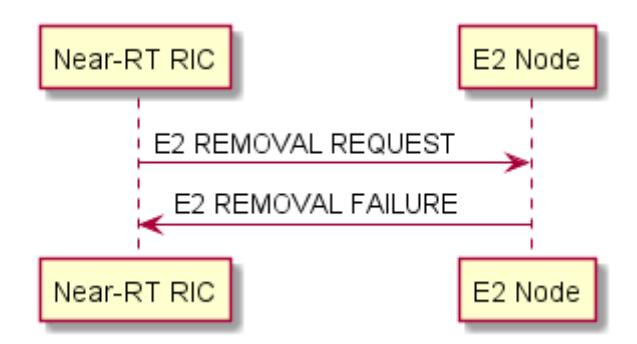

The image illustrates a flowchart for an E2 Removal request process involving two nodes: a Near-RT RIC and an E2 Node. There are two arrows initiating from the Near-RT RIC towards the E2 Node, each labeled 'E2 Removal Request'. Simultaneously, there are two arrows pointing from the E2 Node back towards the Near-RT RIC, each labeled 'E2 Removal Failure'.


: 

In [ ]:
captioner = ImageCaptioner(system_prompt="""
    You are a helpful assistant that generates captions for ORAN and 5G related images.
    Your task is to provide a concise and accurate description of the image content.
    Please ensure that your captions are informative and relevant to the context of the image.
    The caption should be in English and should not include any personal opinions or irrelevant information.
    The caption should be capable of being used in a technical report or documentation and replacing the image
    Indicate where all arrows begin and end in the image.
 """)

res= captioner.generate_caption(base64_string= base64_s)

print(res)  # Output the generated caption